# State of the Union
[WikiPage](https://en.wikipedia.org/wiki/State_of_the_Union)

The address not only reports on the condition of the nation but also allows the President to outline his legislative agenda (for which he needs the cooperation of Congress) and national priorities.


In [48]:
import csv, json
# How to install Stanford Parser to nltk, I didn't use it eventually.
# http://stackoverflow.com/questions/13883277/stanford-parser-and-nltk/34112695#34112695
from nltk.tokenize import StanfordTokenizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [37]:
FILE_NAME = 'state-of-the-union.csv'
csv.field_size_limit(1000000000)

speech_data = open(FILE_NAME)
speeches = csv.reader(speech_data)

# while reading with csv reader, values are seperated by , in each row.
# Extract only the document here
years, docs = [list(a) for a in zip(*speeches)]

# Corpus Preprocessing

In [157]:
# 1. Lower all letter first
# 2. Remove contractions
# 3. tokenize
# 4. remove stopwords and punctuation

# replace contraction
docs = [doc.lower() for doc in docs]
docs = [expandContractions(doc) for doc in docs]

# remove header
# header means information like 
docs = [remove_header(doc) for doc in docs]

# tokenize
stop_words = stopwords.words('english')
texts = [[ token for token in word_tokenize(doc) ] for doc in docs]
texts = [[token for token in text if not token in stop_words] for text in texts]

# remove punctuations
texts = [[token for token in text if not isPunctuation(token)] for text in texts]

### Stemming
Why? In several previous model building, we see terrorists and terrorist as different features. I don't think this gives me less information about the topic that I'm modeling. By combining them, I believe it could show me more other word features.

### Porter Stemmer


In [158]:
# Stemming
# REF: http://www.nltk.org/api/nltk.stem.html

from nltk.stem.porter import *
stemmer = PorterStemmer()

texts = [[stemmer.stem(token) for token in text] for text in texts]

In [159]:
# remove words that appeared only once
# consider? Why one? Why not two?
from collections import defaultdict
frequency = defaultdict(int)

for text in texts:
    for token in text:
        frequency[token] += 1
        
texts = [[token for token in text if frequency[token] > 1] 
         for text in texts]

In [177]:
from gensim import models, corpora
dictionary = corpora.Dictionary(texts)

# take a peek that it actually got converted
# print(dictionary)
# print(dictionary.token2id)

Dictionary(10933 unique tokens: ['reli', 'undeclar', 'dislik', 'p.', 'curs']...)


In [161]:
# turn all the documents into bag of words representation
corpus = [dictionary.doc2bow(text) for text in texts]

In [162]:
# Initialize tf-idf model
tfidf = models.TfidfModel(corpus)

In [239]:
tfidf_corpus = tfidf[corpus]
lsi = models.LsiModel(tfidf_corpus, id2word=dictionary, num_topics=100)

In [240]:
# show the latent space...
lsi.show_topics()

[(0,
  '-0.093*"program" + -0.079*"upon" + -0.066*"tonight" + -0.066*"help" + -0.062*"territori" + -0.061*"mexico" + -0.060*"job" + -0.060*"bank" + -0.058*"indian" + -0.058*"subject"'),
 (1,
  '-0.207*"program" + -0.206*"tonight" + -0.172*"job" + -0.155*"help" + -0.133*"budget" + -0.110*"today" + -0.106*"billion" + -0.098*"spend" + -0.098*"soviet" + -0.097*"percent"'),
 (2,
  '-0.202*"tonight" + -0.120*"terrorist" + 0.106*"program" + -0.106*"job" + -0.099*"iraq" + 0.095*"method" + 0.095*"interst" + 0.086*"cent" + -0.078*"iraqi" + 0.077*"farm"'),
 (3,
  '0.214*"program" + -0.158*"tonight" + -0.140*"terrorist" + 0.134*"communist" + -0.122*"silver" + -0.116*"iraq" + 0.100*"soviet" + -0.096*"gold" + -0.094*"iraqi" + 0.093*"atom"'),
 (4,
  '-0.202*"terrorist" + -0.161*"iraq" + -0.143*"iraqi" + 0.141*"program" + -0.138*"interst" + 0.116*"soviet" + 0.115*"silver" + 0.110*"gold" + 0.106*"mexico" + 0.094*"communist"'),
 (5,
  '-0.318*"terrorist" + -0.245*"iraq" + -0.230*"iraqi" + -0.134*"terror

In [241]:
# Show the result of each document projected into the latent space.
corpus_lsi = lsi[tfidf_corpus]
for i, c_lsi in enumerate(corpus_lsi):
    print("{}th document: {}".format(i, sorted(c_lsi, key=lambda x: x[1], reverse=True)[0:3] ))

0th document: [(79, 0.20743023360731505), (8, 0.15289166626959613), (40, 0.14400184420370116)]
1th document: [(68, 0.29033819584891851), (83, 0.18532807020783454), (8, 0.17703136174048367)]
2th document: [(70, 0.16193630355457653), (8, 0.1559794540450605), (72, 0.15513109919360835)]
3th document: [(21, 0.22464808083269053), (8, 0.19053923227576947), (59, 0.18340910671294627)]
4th document: [(81, 0.20817525304862353), (8, 0.16434048888805863), (89, 0.14144091344030837)]
5th document: [(8, 0.23639403592896394), (69, 0.20705917604843316), (67, 0.16412096444110352)]
6th document: [(79, 0.19354775512530259), (86, 0.18608734096425361), (6, 0.16574357977126919)]
7th document: [(30, 0.17616352715340233), (41, 0.16389137484349534), (1, 0.15687869829488454)]
8th document: [(11, 0.25439362041672231), (99, 0.22749420759760869), (30, 0.19034400619228503)]
9th document: [(51, 0.19240603641279658), (11, 0.19169836574200222), (41, 0.18152913694186107)]
10th document: [(11, 0.26771086274721634), (49, 0

# Figuring out what's the best number of topics
By selecting too small amount, they all go to the same topics, and by selecting too many the all belong to thier own. Try to run over a series of value and try to find an appropriate number for topics by plotting. According to some of the googling online, the best way of figuring out the number of topics is to compare the result and pick one that best fits my requirements. 

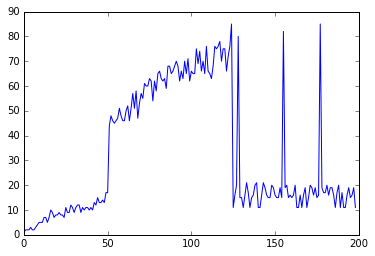

In [246]:
span = []
for k in range(1, 200):
    lsi = models.LsiModel(tfidf_corpus, id2word=dictionary, num_topics=k)
    # Show the result of each document projected into the latent space.
    corpus_lsi = lsi[tfidf_corpus]
    used_topics = set()
    for i, c_lsi in enumerate(corpus_lsi):
        # find max probability topic for each doc
        max_tuple = max(c_lsi, key=lambda x: x[1])
        used_topics.add(max_tuple[0])
    
    span.append(len(used_topics))
    
import matplotlib.pyplot as plt
%matplotlib inline  
plt.plot(span)
plt.show()

# Observing the above plotting result
The horizontal axis is `k`, the number of topics. The vertical axis means the number of appeared unique topics(I only used the topic with highest probability, and this is dangerous since probabilist LSA gives the power of having multiple topics in a document). For example if the four documents are to be projected into {1,1,2,2}, than the value is going to be 2. In my opinion, I think there are three phases in this progress. 

### The first phase:
There are still not much projection spaces that could be taken into consideration, and thus the most appeared words are just going to be considered as importance features for topics. Taking `k=2` for consideration, if they have a large amount of word count, it means that it is probably included in a lot of documents, and the process of projecting is to find the largest variance between the two topics, than if there appears to have several documents that doens't use this much of these vocabularies, than the variance would be big, and this projection would be selected. Like **program: 1238, upon:3939, tonight: 464, mexico: 852, job: 624...**. There are also a lot of token that appears even more times but I believe it's just that they are seperated more evenly between documents, like **State: 8689, nation: 5995, govern: 7917.**

### First phase result, e.g. k = 2
[(0,
  '0.093*"program" + 0.079*"upon" + 0.066*"tonight" + 0.066*"help" + 0.062*"territori" + 0.061*"mexico" + 0.060*"job" + 0.060*"bank" + 0.058*"indian" + 0.058*"subject"'),
 (1,
  '0.207*"program" + 0.206*"tonight" + 0.172*"job" + 0.155*"help" + 0.133*"budget" + 0.110*"today" + 0.106*"billion" + 0.098*"spend" + 0.098*"soviet" + 0.097*"percent"')]



### The second Phase:
In this phase, I think it's where documents specific features get to be seen. I'm not sure about the big jump there, but I hope that's a sign that features of really general terms get to be excluded since that point around `k=50`. During this phase, diverse topics get to be included. The topics here might not be the one that we're trying to map such as **employment, international affairs, resources, interstate affair and war.** The documents here are kind of struggling to get out of the really generic classification of phase one. A lot of documents are categorized into the first(idx=0) topic. This topic has some really interesting features. 

```
[('program', -0.093397124480330732), ('upon', -0.079132591127145019), ('tonight', -0.06623436012454928), ('help', -0.066176780870599569), ('territori', -0.061835811291247961), ('mexico', -0.06058065025508811), ('job', -0.060119986642816238), ('bank', -0.059575397169012188), ('indian', -0.058327010714429327), ('subject', -0.058196360566384039)]
```

This is a topic with only negative features, which means documents in this category are the ones that are just far from the others, but the have yet find out what's special among them. The following two blocks are plotting the topic modeling result of case k=100 as an example.

### Second phase result, e.g. k = 100

In [273]:
# Taking k=100 as an example.
lsi_100 = models.LsiModel(tfidf_corpus, id2word=dictionary, num_topics=100)
topic_100_counter = {}
doc_100_topics = lsi_100[tfidf_corpus]
for doc in doc_100_topics:
    # find the topic category with the highest probability
    # and count it
    max_tuple = max(doc, key=lambda x: x[1])
    if not max_tuple[0] in topic_100_counter:
        topic_100_counter[max_tuple[0]] = 1
    else:
        topic_100_counter[max_tuple[0]] += 1
        
print(topic_100_counter)

{1: 32, 2: 16, 3: 11, 4: 12, 5: 11, 6: 9, 7: 6, 8: 5, 9: 3, 10: 2, 11: 6, 12: 3, 13: 4, 14: 4, 15: 4, 16: 3, 17: 5, 19: 3, 20: 4, 21: 2, 22: 1, 23: 1, 24: 1, 26: 3, 27: 3, 30: 3, 31: 4, 32: 1, 33: 1, 34: 2, 35: 1, 36: 1, 37: 1, 38: 1, 40: 4, 41: 1, 42: 1, 43: 2, 45: 1, 46: 2, 47: 1, 48: 2, 49: 1, 50: 2, 52: 2, 53: 1, 56: 2, 57: 1, 58: 2, 59: 1, 61: 1, 63: 2, 64: 1, 69: 1, 70: 1, 71: 2, 72: 1, 73: 2, 74: 2, 75: 1, 76: 1, 79: 1, 80: 1, 81: 3, 82: 2, 83: 1, 84: 2, 89: 1, 90: 2, 91: 1, 93: 1, 94: 1}


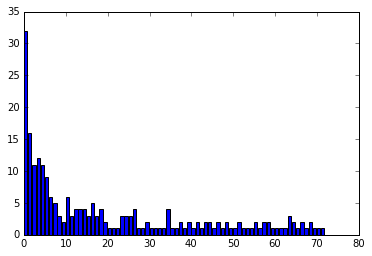

[('program', -0.20676388928033471), ('tonight', -0.20590187697144197), ('job', -0.17221190601136055), ('help', -0.15508803524779805), ('budget', -0.13332979718538762), ('today', -0.11001625329195873), ('billion', -0.10566912698349767), ('spend', -0.097900323722962312), ('soviet', -0.097579058030101806), ('percent', -0.09673352792625646)]


In [274]:
import numpy as np
plt.bar(np.arange(len(topic_100_counter.keys())), topic_100_counter.values())
plt.show()

# show the feautures of the first topic.

print(lsi_100.show_topic(1))

### Third Phase

Ok, to be honest, I was hoping that the third phase was a converged result of several outstanding topics, but turned out they are back to crap. Therefore I guess I will pick the number from the range **50-130**.
Or maybe this data just reveiled that during most of the State of the union speech, they talk a lot about **bank, terrorist, helping allies, providing jobs and such...**

The following visualized the counting of the topic with highest probability for each documents. 

{0: 207, 33: 1, 75: 1, 6: 1, 38: 1, 39: 1, 9: 2, 10: 1, 43: 1, 13: 3, 78: 1, 45: 1, 49: 1, 53: 1, 54: 1, 46: 1, 47: 1}


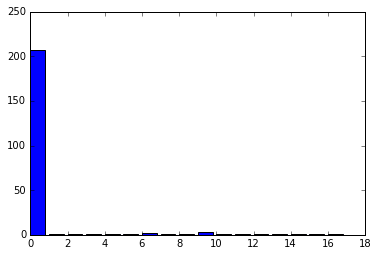

[('program', 0.093397437503941388), ('upon', 0.079132722230692176), ('tonight', 0.06623518088964786), ('help', 0.06617683724780353), ('territori', 0.061835567385379729), ('mexico', 0.060580161569276605), ('job', 0.060119803006730213), ('bank', 0.059574858193892855), ('indian', 0.05832620352689992), ('subject', 0.058195957759279889)]


In [275]:
# Taking k=130 as an example.
lsi_130 = models.LsiModel(tfidf_corpus, id2word=dictionary, num_topics=130)
topic_130_counter = {}
doc_130_topics = lsi_130[tfidf_corpus]
for doc in doc_130_topics:
    # find the topic category with the highest probability
    # and count it
    max_tuple = max(doc, key=lambda x: x[1])
    if not max_tuple[0] in topic_130_counter:
        topic_130_counter[max_tuple[0]] = 1
    else:
        topic_130_counter[max_tuple[0]] += 1
        
print(topic_130_counter)

plt.bar(np.arange(len(topic_130_counter.keys())), topic_130_counter.values())
plt.show()

# show the feautures of the first topic.
print(lsi_130.show_topic(0))

In [ ]:
# Just for fun, plotting the top three 

This speech was addressed in 1905, and the index is 116
This speech was addressed in 1906, and the index is 117
This speech was addressed in 1907, and the index is 118
This speech was addressed in 1911, and the index is 122
This speech was addressed in 1912, and the index is 123
This speech was addressed in 1946, and the index is 156
This speech was addressed in 1981, and the index is 193


In [ ]:
docs[223]

In [154]:
# REF: http://devpost.com/software/contraction-expander
# before doing this, there were a lot of "'t" and "'re" in the lsi model, which wasn't helpful at all.
# Well, I mean mathametically it does tell me that it appears pretty often, but not mapping any topic to the real world.
# After doing this, more useful words appeared.

import re
contraction_file = open('./contraction.json')
contraction_dict = json.load(contraction_file)
c_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))

def expandContractions(text, c_re=c_re):
    def replace(match):
        return contraction_dict[match.group(0)]
    return c_re.sub(replace, text)

In [155]:
# The reason of writing this function is that I observed that part of the speeches included gentlmen while they 
# adress this speech. We can claim that how you start your speech is a feature, but I don't think this is
# what we're trying to do, as topic modeling here. Therefore I believe by removing the date, year, name of president
# we can have better and clearer view of what the content of the speech really is. 
# (To be honest the president's name doesn't have a great impact on the model)

def remove_header(doc):
    '''
    A function that returns a shorten document that removed the date of the state of union speech,
    the speaker, and most important of all, who this speech is addressed to. Implemented by finding the first ":". 
    Some cases doesn't match this condition and thus, We remove all the text before the appearance of 19xx, by 
    using regex.
    
    INPUT: doc - string
    return: string
    '''
    
    # find the first appearance of :, if it's close to the start of document enough than we are
    # sure that it has finished addressing the congress and fellow americans
    addressing = doc[0: (doc.find(':') + 1)]
    if len(addressing) > 250:
        match = re.search('[0-9][0-9][0-9]+', doc[0:200])
        if match:
            return doc[match.start()+4:]
    else:
        return doc[doc.find(":") + 1:]
    

In [156]:
import string

def isPunctuation(token):
    '''
    Implemented this function is to include the special case of the appearance of 
    -- string. There are so many of them in the document that it became a feature.
    In my opinion, this kind of use doesn't really have a direct mapping of the content
    this speaker is talking about. You can argue that it is more of how often the speaker 
    use this kind of pattern.
    
    Writing this function gives me a space to tackle all problems of punctuation, and better code
    readability.
    
    INPUT: token - string
    RETURN: boolean
    '''
    if token == '--':
        return True
    if token in string.punctuation:
        return True
    else:
        return False
    

# Special Cases discovered
1. william h. taft, december 7, 1909. He didn't address the speech to a particular group of people, or is it just missing from the data
2. Gentlemen of the congress, I don't know whether this is sexist or not...
3. calvin coolidge, decemeber 6, 1923. He didn't address the speech to a particular group as well.
4. dwight d. eisenhower address the 86th congress

[How to update StanfordParser?](http://stackoverflow.com/questions/13883277/stanford-parser-and-nltk/34112695#34112695)

# 1.3 Do LSI Topic Modeling

#### References
- [A read for reviewing LSI](http://lsa.colorado.edu/papers/dp1.LSAintro.pdf)
- [Stanford NLP LSI intro](http://nlp.stanford.edu/IR-book/html/htmledition/latent-semantic-indexing-1.html)



### Randomly select ten topics to annotate
At first I randomly picked 30 as the number of topics that I want without any reason. These are some of the topics combination.
```
[(0,
  '0.093*"program" + 0.079*"upon" + 0.066*"tonight" + 0.066*"help" + 0.062*"territori" + 0.061*"mexico" + 0.060*"job" + 0.060*"bank" + 0.058*"indian" + 0.058*"subject"'),
 (1,
  '-0.207*"program" + -0.206*"tonight" + -0.172*"job" + -0.155*"help" + -0.133*"budget" + -0.110*"today" + -0.106*"billion" + -0.098*"spend" + -0.098*"soviet" + -0.097*"percent"'),
 (2,
  '0.202*"tonight" + 0.120*"terrorist" + -0.106*"program" + 0.106*"job" + 0.100*"iraq" + -0.095*"method" + -0.095*"interst" + -0.086*"cent" + 0.078*"iraqi" + -0.077*"farm"'),
...
...
...
 (23,
  '-0.122*"communist" + -0.116*"1911" + -0.096*"gold" + -0.086*"job" + -0.086*"wool" + -0.077*"texa" + -0.077*"1910" + 0.075*"french" + -0.073*"1909" + -0.070*"deficit"'),
 (24,
  '-0.134*"..." + 0.102*"vietnam" + 0.098*"job" + 0.096*"soviet" + 0.095*"1827" + 0.082*"silver" + -0.079*"insurg" + 0.079*"recoveri" + -0.079*"1899" + 0.078*"communist"'),
 (25,
  '0.134*"gold" + -0.120*"..." + -0.114*"wool" + -0.105*"vietnam" + 0.104*"silver" + -0.102*"insurg" + -0.095*"tariff" + 0.082*"1827" + 0.081*"currenc" + 0.078*"circul"'),
 (26,
  '-0.162*"wool" + -0.136*"1911" + 0.113*"1899" + 0.105*"cuba" + 0.101*"1898" + 0.095*"recoveri" + -0.093*"goal" + -0.091*"tariff" + -0.086*"1909" + 0.084*"1897"'),
 (27,
  '-0.265*"..." + -0.126*"1946" + -0.125*"1947" + -0.120*"soviet" + -0.114*"1947." + -0.100*"1945" + -0.100*"tonight" + 0.084*"today" + -0.077*"bargain" + -0.075*"budget"'),
 (28,
  '-0.114*"1892" + -0.099*"goal" + -0.095*"bank" + -0.084*"1891" + -0.082*"1890" + 0.080*"wool" + -0.072*"92d" + -0.068*"philadelphia" + 0.067*"budget" + 0.064*"saddam"'),
 (29,
  '-0.131*"21st" + 0.107*"communist" + -0.103*"oil" + -0.101*"saddam" + 0.100*"dream" + -0.096*"challeng" + -0.087*"medicar" + 0.082*"deficit" + -0.081*"hussein" + 0.080*"spend"')]
```

### Randomly Selected Annotations
#### Topic 12
```
(12,
  '0.218*"mexico" + 0.184*"texa" + 0.128*"mexican" + 0.097*"enemi" + 0.089*"annex" + -0.086*"slaveri" + -0.086*"spain" + 0.085*"1942" + -0.083*"slave" + 0.083*"1911"')
```
- This topic has the highest feature weight for mexican + mexico in the given 30 topics that I picked. It also has a positive value for Texas. I checked several documents that has the most weight on this topic, for example document 56, in 1845. It was the time where Texas just about to join the union. The appearance of annex, the prefix of annexation, also showed another important feature of this topic. At that time, Mexico, paid a visit to the states and expressed their opinion on Texas joining the union and the speaker spent a long paragraph commenting on that. In short, this topic is mainly about Texas joining the union, and the speech from 1845-1857 should all be classified as this topic.

#### Topic 29
```
(29,
  '-0.131*"21st" + 0.107*"communist" + -0.103*"oil" + -0.101*"saddam" + 0.100*"dream" + -0.096*"challeng" + -0.087*"medicar" + 0.082*"deficit" + -0.081*"hussein" + 0.080*"spend"')
```
- This topic has oil, 21st, medicare and dream in it. It sounds like a modern speech given by Obama. It also has 'deficit' with a positive coefficient in the topic, which only appeared twice, among all 30 topics. This probably means that these corpus are somewhere near the time of a serious deficit. I checked the several documents that has the highest probability of being categorized as this topic, there are two, 2010 and 2011, where the second worst deficit ever happened to the U.S. In short, I would say this category are about **21st century challenges and dreams of the States.**




In [283]:
# Picking 100 as topics and random selecting ten topics to annotate.
lsi_pick = models.LsiModel(tfidf_corpus, id2word=dictionary, num_topics=100)

# randomly pick ten from its topics
from random import sample
ten_topics = sample(lsi_pick.show_topics(), 10)
ten_topics

[(19,
  '0.209*"soviet" + -0.158*"job" + 0.132*"democraci" + -0.127*"japanes" + -0.114*"program" + -0.112*"1942" + -0.093*"hitler" + 0.085*"savag" + -0.084*"nurs" + 0.081*"tonight"'),
 (35,
  '-0.129*"democraci" + 0.115*"wool" + -0.096*"1892" + -0.089*"seminari" + 0.087*"missil" + -0.085*"california" + 0.085*"..." + -0.084*"1890" + 0.076*"savag" + 0.071*"sheep"'),
 (0,
  '-0.093*"program" + -0.079*"upon" + -0.066*"tonight" + -0.066*"help" + -0.062*"territori" + -0.061*"mexico" + -0.060*"job" + -0.060*"bank" + -0.058*"indian" + -0.058*"subject"'),
 (17,
  '-0.119*"kansa" + 0.117*"job" + 0.108*"oil" + -0.099*"communist" + -0.093*"1890" + 0.090*"speci" + 0.090*"1869" + 0.088*"enemi" + -0.088*"1892" + -0.088*"democraci"'),
 (64,
  '-0.096*"cabl" + -0.083*"1973" + 0.083*"soviet" + -0.081*"..." + 0.071*"eight-hour" + 0.068*"exchequ" + 0.067*"battleship" + 0.062*"scout" + 0.060*"submarin" + 0.058*"1888"'),
 (93,
  '-0.099*"cabl" + 0.090*"wool" + -0.074*"eight-hour" + 0.071*"decre" + 0.063*"sp

In [ ]:
# Show all documents that 
topic_index = 66

lsi_pick_result = lsi_pick[tfidf_corpus]
for i, doc in enumerate(lsi_pick_result):
    if doc[topic_index][1] > 0.1:
        print('idx:{}, year:{},:{}'.format(i, years[i],docs[i]))
# lsi_pick[tfidf_corpus][10]

# Ten Annotations for Seriously Selected topics k = 100

`(19, '0.209*"soviet" + -0.158*"job" + 0.132*"democraci" + -0.127*"japanes" + -0.114*"program" + -0.112*"1942" + -0.093*"hitler" + 0.085*"savag" + -0.084*"nurs" + 0.081*"tonight"')`
- I think this one is pretty clear that they are talking something Japanese, Hitlar and Soviet are all involved and happened between 1939-1945.

`(35, '-0.129*"democraci" + 0.115*"wool" + -0.096*"1892" + -0.089*"seminari" + 0.087*"missil" + -0.085*"california" + 0.085*"..." + -0.084*"1890" + 0.076*"savag" + 0.071*"sheep"')`
- This one seems to care a lot about sheep and wool. I searched and found his name -- Grover Cleveland, he indeed cares a lot about farmers and veterans.

`(0, '-0.093*"program" + -0.079*"upon" + -0.066*"tonight" + -0.066*"help" + -0.062*"territori" + -0.061*"mexico" + -0.060*"job" + -0.060*"bank" + -0.058*"indian" + -0.058*"subject"')`
- Most of them are negative and a lot of documents seems to have a large probability of dropping into this topic, this might just be a topic that's really far away from other topics.

`(17, '-0.119*"kansa" + 0.117*"job" + 0.108*"oil" + -0.099*"communist" + -0.093*"1890" + 0.090*"speci" + 0.090*"1869" + 0.088*"enemi" + -0.088*"1892" + -0.088*"democraci"')`
- I guess this kind of speech mentioned a lot of data or historical events during the State of the union speech. 

`(64, '-0.096*"cabl" + -0.083*"1973" + 0.083*"soviet" + -0.081*"..." + 0.071*"eight-hour" + 0.068*"exchequ" + 0.067*"battleship" + 0.062*"scout" + 0.060*"submarin" + 0.058*"1888"')`
- I am guessing this is during the war since it's related to soviet, battleship, submarine and cables. I looked for speeches that has higher than 20% probability of being categorized in this topic, it's an event about going to WWI.

`(93, '-0.099*"cabl" + 0.090*"wool" + -0.074*"eight-hour" + 0.071*"decre" + 0.063*"spanish" + -0.059*"seed" + -0.057*"hire" + 0.057*"democraci" + 0.057*"nomine" + 0.056*"1975"')`
- I searched for documents with probability higher than 15% being in this topic(since there's no document higher than 20% for this). This kind of documents might be talking about Europe governments and decrees.

`(37, '0.113*"saddam" + 0.106*"1973" + 0.090*"iraq" + -0.087*"nuclear" + -0.085*"terrorist" + 0.084*"vietnam" + -0.073*"poverti" + 0.072*"atom" + -0.069*"seminari" + -0.068*"emancip"')`
- Speech about USA having problem with Iraq, Saddam and terrorist.

`(70, '-0.108*"1973" + 0.092*"acr" + 0.080*"greytown" + 0.075*"nomine" + 0.069*"cyan" + -0.064*"1884" + 0.064*"1893" + -0.064*"decre" + -0.060*"polygami" + 0.058*"huerta"')`
- Speech about USA tackling Victoriano Huerta. It's still probably about war since Cyane seems to be a ship.

`(77, '0.105*"wool" + -0.077*"texa" + 0.066*"disavow" + -0.064*"unrest" + -0.062*"eighti" + -0.062*"convent" + 0.058*"panama" + 0.055*"communist" + -0.055*"1878" + -0.055*"stipul"')`
- I guess there's an unrest in Panama? No not at all, I don't know what is this category about.

`(66, '-0.096*"program" + 0.093*"inflat" + -0.078*"unrest" + 0.077*"democraci" + -0.075*"circuit" + -0.068*"democrat" + 0.068*"billion" + -0.064*"challeng" + -0.063*"panama" + -0.062*"1932"')`
- I think this kind of topic is also pretty general, billion might be speakers highlighting how much money they took or spent from the taxpayer.

# 1.4 Now Do LDA topic modeling
- [How does alpha and beta affect the model?](http://datascience.stackexchange.com/questions/199/what-does-the-alpha-and-beta-hyperparameters-contribute-to-in-latent-dirichlet-a)
- [Natural Interpretation for LDA hyperparameters](http://stats.stackexchange.com/questions/37405/natural-interpretation-for-lda-hyperparameters)

Assuming symmetric Dirichlet distributions (for simplicity), a low alpha value places more weight on having each document composed of only a few dominant topics (whereas a high value will return many topics contributing to the document). Similarly, a low beta value places more weight on having each topic composed of only a few dominant words.

alpha-parameters specify prior beliefs about topic sparsity/uniformity in the documents. 


### Picking number of topics
I tried several hundreds and the result turned out to become a combination of a lot of topics. In order to narrow topics down, I prefered lower num_topics.

# Ten Annotations


`(111, '0.002*job + 0.002*iraq + 0.002*program + 0.002*today + 0.002*iraqi + 0.002*help + 0.001*tonight + 0.001*terrorist + 0.001*achiev + 0.001*communist')`
- This looks like a combination of a lot of general terms like "tonight, I am talking in front of you...", like we got to make more "jobs". But it also includes two iraq related terms.

`(86, '0.002*mexico + 0.001*cabl + 0.001*mexican + 0.001*1847 + 0.001*1846 + 0.001*territori + 0.001*steamer + 0.001*indemn + 0.001*ironclad + 0.001*telegraph')`
- A topic about mexico(mexican, mexico) and cables(cable, telegraph).

`(45, '0.002*sea-men + 0.001*natchez + 0.001*esq. + 0.001*commission + 0.001*cathol + 0.001*french + 0.001*majesti + 0.001*algier + 0.001*country-men + 0.001*regenc')`
- A topic of relatively old terms like sea-men and country-men. 

`(4, '0.003*wool + 0.002*kid + 0.002*markwel + 0.002*tonight + 0.002*1911 + 0.001*statut + 0.001*panama + 0.001*anti-trust + 0.001*drug-fre + 0.001*today')`
- A topic about fighting drugs for kids. year: 1990

`(21, '0.001*nontax + 0.001*mandamu + 0.001*royalti + 0.001*hinder + 0.001*bushel + 0.001*circuit + 0.001*valuat + 0.001*tariff + 0.001*centum + 0.001*reclam')`
- tax related, including nontax, tariff. I guess bushel comes along as well.

`(25, '0.002*seventi + 0.002*clean + 0.002*program + 0.001*wool + 0.001*sheep + 0.001*tariff + 0.001*air + 0.001*today + 0.001*blame + 0.001*america')`
- farmer related topics. Wool, sheep, tariff. Also about environment, because of clean and air.

`(87, '0.003*program + 0.002*communist + 0.002*atom + 0.001*1951 + 0.001*help + 0.001*laugh + 0.001*korea + 0.001*disarma + 0.001*curtain + 0.001*fight')`
- World War two related. Atom(nulcear), fight, communist, disarm

`(66, '0.003*1973 + 0.002*soviet + 0.002*domingo + 0.002*program + 0.001*san + 0.001*goal + 0.001*spend + 0.001*texa + 0.001*plagu + 0.001*i.e.')`
- I don't think this means anything to me.

`(27, '0.000*timidli + 0.000*label + 0.000*partit + 0.000*importantli + 0.000*rid + 0.000*arabl + 0.000*thirty-two + 0.000*paint + 0.000*blot + 0.000*178')`
- I don't think this means anything

`(32, '0.002*unrest + 0.001*antagon + 0.001*dyestuff + 0.001*storag + 0.001*interst + 0.001*programm + 0.000*enmiti + 0.000*workman + 0.000*malevol + 0.000*shipment')`
- It feels like some pretty industrial topic, since it has storage, dyestuff, workman and shipment in it.



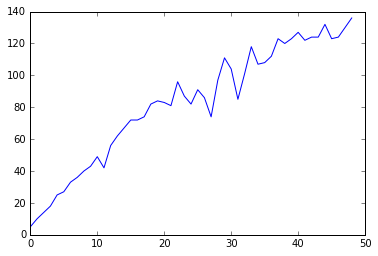

In [392]:
# I am trying to do the same thing for LDA, but seems like it doesn't fall...
# Also I do it with a 
lda_span = []
for k in range(1, 50):
    _lda = models.LdaModel(tfidf_corpus, id2word=dictionary, num_topics=k*5)
    # Show the result of each document projected into the latent space.
    corpus_lda = _lda[tfidf_corpus]
    used_topics = set()
    for i, c_lda in enumerate(corpus_lda):
        # find max probability topic for each doc
        max_tuple = max(c_lda, key=lambda x: x[1])
        used_topics.add(max_tuple[0])
    
    lda_span.append(len(used_topics))
    
# import matplotlib.pyplot as plt
# %matplotlib inline  
plt.plot(lda_span)
plt.show()

In [364]:
lda = models.LdaModel(tfidf_corpus, num_topics=120, id2word=dictionary)

In [365]:
sample( lda.show_topics(),10)

[(111,
  '0.002*job + 0.002*iraq + 0.002*program + 0.002*today + 0.002*iraqi + 0.002*help + 0.001*tonight + 0.001*terrorist + 0.001*achiev + 0.001*communist'),
 (86,
  '0.002*mexico + 0.001*cabl + 0.001*mexican + 0.001*1847 + 0.001*1846 + 0.001*territori + 0.001*steamer + 0.001*indemn + 0.001*ironclad + 0.001*telegraph'),
 (45,
  '0.002*sea-men + 0.001*natchez + 0.001*esq. + 0.001*commission + 0.001*cathol + 0.001*french + 0.001*majesti + 0.001*algier + 0.001*country-men + 0.001*regenc'),
 (4,
  '0.003*wool + 0.002*kid + 0.002*markwel + 0.002*tonight + 0.002*1911 + 0.001*statut + 0.001*panama + 0.001*anti-trust + 0.001*drug-fre + 0.001*today'),
 (21,
  '0.001*nontax + 0.001*mandamu + 0.001*royalti + 0.001*hinder + 0.001*bushel + 0.001*circuit + 0.001*valuat + 0.001*tariff + 0.001*centum + 0.001*reclam'),
 (25,
  '0.002*seventi + 0.002*clean + 0.002*program + 0.001*wool + 0.001*sheep + 0.001*tariff + 0.001*air + 0.001*today + 0.001*blame + 0.001*america'),
 (87,
  '0.003*program + 0.002

In [366]:
lda_corpus = lda[tfidf_corpus]

In [391]:
# this section is used to show the year and index of the speech so I can check the content in the 
# speech.

target_topic = 32
for i, lda_c in enumerate(lda_corpus):
    found = [l for l in lda_c if l[0] == target_topic and l[1] >= 0.05]
    if found:
        print("id: {}, year: {}-{}".format(i, years[i], str(lda_c)))
        print('')

In [360]:
lda.show_topic(20)

[('program', 0.0012172184975938435),
 ('help', 0.00086510351967477098),
 ('tonight', 0.00085968305284827185),
 ('today', 0.0007498672695697955),
 ('goal', 0.00073202147911998936),
 ('america', 0.00073006524339202595),
 ('job', 0.00066311048009848892),
 ('kid', 0.00057308696027047511),
 ('technolog', 0.00054327639582105495),
 ('percent', 0.00053139059857752107)]

# How topics of speeches have changed over time?
use LDA and group after modeling.

In [463]:
from math import floor
# in a decade, we sum up the probabilities of the same topics and show text from top 5, 
# excluding the topic that all decades have in common

# the index that starts from 1901
yidx = 112

# save the index for data of that bucket,
# some times there are more than 10 state of the union speech
# solution: use 190 as key for 1901-1910 data. 
# some special cases are manually solved already.
decade_bucket = {}

# put all the indices into this bucket and we can work with
# this bucket later
while yidx < len(years):
    decade_key = floor((int(years[yidx]) - 1)/10)
    if not decade_key in decade_bucket:
        decade_bucket[decade_key] = [yidx]
    else:
        decade_bucket[decade_key].append(yidx)
    yidx += 1


# we do calculation for each decade
for decade in sorted(decade_bucket.keys()) :
    
    print("{}:".format(decade*10 + 1))
    # a list of indices
    decade_data = decade_bucket[decade]
    
    # key value pair, key: topic id, value: sum of topic probability
    decade_topics = {}
    
    for idx in decade_data:
        topic = lda_corpus[idx]
        for t in topic:
            if not t[0] in decade_topics:
                decade_topics[t[0]] = t[1]
            else:
                decade_topics[t[0]] += t[1]

    # find the top 5 topics
    top_topics = sorted( list(decade_topics.items()), key=lambda x: x[1], reverse=True)[0:8]
    top_topics = [t for t in top_topics if t[0] != 111]
    
    decade_words = []
    for t in top_topics:
        words = lda.show_topic(t[0])
        words = [w[0] for w in words]
        print(words)
        # decade_words.extend(words)
    
    # because it's for my own observation, so I remove duplicate words...
    # print(', '.join(set(decade_words)))
    print('')
    

1901:
['anarchist', 'forest', 'embargo', 'wage-work', 'suspens', 'decre', 'interst', 'deforest', 'edict', 'corpor']
['lake', 'get', 'tribe', 'tell', 'help', 'forest', 'eri', 'yeltsin', 'tonight', 'job']
['barrel', 'oil', '1869', 'cabl', 'texa', 'billion', 'program', 'quick', 'spain', 'per']
['1911', '1859', '1910', '1876', 'slave', '1912', 'estim', 'montenegro', 'auditor', 'zelaya']
['cabl', 'commission', 'captur', 'damag', 'philadelphia', 'french', 'holland', 'corpor', 'gentlemen', 'consul']
['spain', 'cathol', 'inflat', 'polygami', 'explan', 'ratifi', 'treati', 'job', 'minist', 'appoint']
['democraci', 'float', 'storag', 'silver', '1891', 'gerrymand', 'elector', 'vessel', 'method', 'isthmu']

1911:
['barrel', 'oil', '1869', 'cabl', 'texa', 'billion', 'program', 'quick', 'spain', 'per']
['program', 'nomine', '1832', 'huerta', 'farmer', 'election', 'royal', 'beg', 'instal', 'payabl']
['democraci', 'float', 'storag', 'silver', '1891', 'gerrymand', 'elector', 'vessel', 'method', 'isthmu'

In [440]:
years[121] = '1910'

# Questions
1. What are the dots: ... in the documents?
ANS: I think it's where the speaker is reading a lot of data...
2. Try to plot all top three topics
3. What is esq.